In [5]:
import numpy as np
import random
import matplotlib.pyplot as plt

from scipy.special import logsumexp
from scipy.stats import pearsonr
from sklearn.linear_model import Ridge
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error

import torch
import torch.distributions as D

import isosplit

from clusterless import preprocess
from clusterless import decoder

In [6]:
seed = 666
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.set_default_dtype(torch.double)

In [7]:
SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 25

plt.rc('font', size=MEDIUM_SIZE)         
plt.rc('axes', titlesize=MEDIUM_SIZE)     
plt.rc('axes', labelsize=MEDIUM_SIZE) 
plt.rc('axes', linewidth = 1.5)
plt.rc('xtick', labelsize=MEDIUM_SIZE)   
plt.rc('ytick', labelsize=MEDIUM_SIZE)   
plt.rc('legend', fontsize=MEDIUM_SIZE)   
plt.rc('figure', titlesize=MEDIUM_SIZE)

#### load data

In [7]:
pid = 'febb430e-2d50-4f83-87a0-b5ffbb9a4943'
rootpath = '/mnt/3TB/yizi/Downloads/ONE/openalyx.internationalbrainlab.org'
trial_data_path = rootpath + '/danlab/Subjects/DY_009/2020-02-27/001/alf'
neural_data_path = '/mnt/3TB/yizi/danlab/Subjects/DY_009'
behavior_data_path = rootpath + '/paper_repro_ephys_data/figure9_10/original_data'
save_path = '../saved_results/danlab/Subjects/DY_009'

In [53]:
roi = 'all'

In [54]:
sorted_trials, good_sorted_trials, unsorted_trials, stim_on_times, np1_channel_map= preprocess.load_neural_data(
    pid=pid, 
    trial_data_path=trial_data_path,
    neural_data_path=neural_data_path,
    behavior_data_path=behavior_data_path,
    keep_active_trials=True, 
    # roi='all',
    roi = roi,
    kilosort=True,
    triage=False,
    good_units=True,
    thresholding=True
)

behave_dict = preprocess.load_behaviors_data(behavior_data_path, pid)
motion_energy, wheel_velocity, wheel_speed, paw_speed, nose_speed, pupil_diameter = preprocess.preprocess_dynamic_behaviors(behave_dict)

pid: febb430e-2d50-4f83-87a0-b5ffbb9a4943
eid: db4df448-e449-4a6f-a0e7-288711e7a75a
found 85 good ibl units ..
1st trial stim on time: 40.81, last trial stim on time 2252.10


In [55]:
class DataLoader():
    def __init__(self, data, y, stim_on_times, np1_channel_map, n_t_bins=30):
        self.data = data
        self.y = y
        self.stim_on_times = stim_on_times
        self.np1_channel_map = np1_channel_map
        self.n_t_bins = n_t_bins
        self.n_trials = stim_on_times.shape[0]
        self.n_channels = np1_channel_map.shape[0]
        self.t_binning = np.arange(0, 1.5, step = (1.5 - 0) / n_t_bins)
        self.rand_trial_ids = np.arange(self.n_trials)
        
        # allocate unsorted data into trials
        self.trial_ids = []
        self.t_ids = []
        self.trials = []
        self.t_bins = []
        for k in range(self.n_trials):
            mask = np.logical_and(data[:,0] >= stim_on_times[k] - 0.5,
                                  data[:,0] <= stim_on_times[k] + 1)
            trial = data[mask,:]
            trial[:,0] = trial[:,0] - trial[:,0].min()
            t_bins = np.digitize(trial[:,0], self.t_binning, right = False) - 1
            t_bin_lst = []
            for t in range(self.n_t_bins):
                t_bin = trial[t_bins == t,1:]
                self.trial_ids.append(np.ones_like(t_bin[:,0]) * k)
                self.t_ids.append(np.ones_like(t_bin[:,0]) * t)
                t_bin_lst.append(t_bin)
            self.trials.append(t_bin_lst)
    
    
    def split_train_test(self, train_ids, test_ids):
        
        self.train_ids = self.rand_trial_ids[train_ids]
        self.test_ids = self.rand_trial_ids[test_ids]
        self.y_train = self.y[self.train_ids]
        self.y_test = self.y[self.test_ids]
        
        trial_ids = np.concatenate(self.trial_ids)
        t_ids = np.concatenate(self.t_ids)
        trials = np.concatenate(np.concatenate(self.trials))

        train_mask = np.sum([trial_ids == idx for idx in self.train_ids], axis=0).astype(bool)
        test_mask = np.sum([trial_ids == idx for idx in self.test_ids], axis=0).astype(bool)
        train_trial_ids, test_trial_ids = trial_ids[train_mask], trial_ids[test_mask]
        train_t_ids, test_t_ids = t_ids[train_mask], t_ids[test_mask]
        train_trials, test_trials = trials[train_mask], trials[test_mask]
        
        return train_trials, train_trial_ids, train_t_ids, \
               test_trials, test_trial_ids, test_t_ids

In [56]:
data_loader = DataLoader(data = np.concatenate(unsorted_trials)[:,[0,1,2,3,4]], 
                         y = paw_speed, 
                         stim_on_times = stim_on_times, 
                         np1_channel_map = np1_channel_map, 
                         n_t_bins=30)

In [57]:
kf = KFold(n_splits=5, shuffle=True, random_state=seed)
# kf = KFold(n_splits=5, shuffle=False)
kf_train_ids = []; kf_test_ids = []
for i, (train_ids, test_ids) in enumerate(kf.split(data_loader.y)):
    kf_train_ids.append(train_ids)
    kf_test_ids.append(test_ids)

In [58]:
i = 0
train_trials, train_trial_ids, train_t_ids, \
test_trials, test_trial_ids, test_t_ids = data_loader.split_train_test(
    train_ids = kf_train_ids[i], test_ids = kf_test_ids[i]
)

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [11]:
sub_weights_lst = []
sub_means_lst = []
sub_covs_lst = []

all_trials = np.vstack([train_trials, test_trials])
for channel in np.unique(all_trials[:,0]):
    sub_s = all_trials[all_trials[:,0] == channel, 1:]
    
    if sub_s.shape[0] > 10:
        try:
            isosplit_labels = isosplit.isosplit(sub_s.T, K_init=20, min_cluster_size=10,
                                                whiten_cluster_pairs=1, refine_clusters=1)
        except AssertionError:
            continue
        except ValueError:
            continue
    elif sub_s.shape[0] < 2:
        continue
    else:
        sub_gmm = GaussianMixture(n_components=1, 
                              covariance_type='full',
                              init_params='k-means++', 
                              verbose=0)
        sub_gmm.fit(sub_s)
        sub_labels = sub_gmm.predict(sub_s)
        sub_weights = len(sub_labels)/len(all_trials)
        sub_weights_lst.append(sub_weights)
        sub_means_lst.append(sub_gmm.means_)
        sub_covs_lst.append(sub_gmm.covariances_)
        continue
    
    n_splits = np.unique(isosplit_labels).shape[0]
    print(f'channel {channel} has {n_splits} modes ...')
    
    if n_splits == 1: 
        sub_gmm = GaussianMixture(n_components=1, 
                              covariance_type='full',
                              init_params='k-means++', 
                              verbose=0)
        sub_gmm.fit(sub_s)
        sub_labels = sub_gmm.predict(sub_s)
        sub_weights = len(sub_labels)/len(all_trials)
        sub_weights_lst.append(sub_weights)
        sub_means_lst.append(sub_gmm.means_)
        sub_covs_lst.append(sub_gmm.covariances_)
    else:
        for label in np.arange(n_splits):
            mask = isosplit_labels == label
            sub_gmm = GaussianMixture(n_components=1, 
                              covariance_type='full',
                              init_params='k-means++', 
                              verbose=0)
            sub_gmm.fit(sub_s[mask])
            sub_labels = sub_gmm.predict(sub_s[mask])
            sub_weights = len(sub_labels)/len(all_trials)
            sub_weights_lst.append(sub_weights)
            sub_means_lst.append(sub_gmm.means_)
            sub_covs_lst.append(sub_gmm.covariances_)
            
sub_weights = np.hstack(sub_weights_lst)
sub_means = np.vstack(sub_means_lst)
sub_covs = np.vstack(sub_covs_lst)

channel 93.0 has 1 modes ...
channel 97.0 has 1 modes ...
channel 101.0 has 1 modes ...
channel 102.0 has 2 modes ...
channel 105.0 has 1 modes ...
channel 106.0 has 1 modes ...
channel 110.0 has 1 modes ...
channel 114.0 has 1 modes ...
channel 116.0 has 1 modes ...
channel 118.0 has 1 modes ...
channel 119.0 has 1 modes ...
channel 120.0 has 1 modes ...
channel 121.0 has 1 modes ...
channel 122.0 has 1 modes ...
channel 124.0 has 3 modes ...
channel 125.0 has 1 modes ...
channel 126.0 has 1 modes ...
channel 131.0 has 1 modes ...
channel 132.0 has 2 modes ...
channel 133.0 has 1 modes ...
channel 134.0 has 2 modes ...
channel 136.0 has 3 modes ...
channel 137.0 has 1 modes ...
channel 138.0 has 2 modes ...
channel 140.0 has 3 modes ...
channel 141.0 has 3 modes ...
channel 142.0 has 2 modes ...
channel 144.0 has 2 modes ...
channel 145.0 has 2 modes ...
channel 146.0 has 1 modes ...
channel 244.0 has 1 modes ...
channel 245.0 has 2 modes ...
channel 246.0 has 2 modes ...
channel 247.

In [12]:
# sub_s_lst = []
# sub_weights_lst = []
# sub_means_lst = []
# sub_covs_lst = []
# for channel in np.unique(train_trials[:,0]):
#     sub_s = train_trials[train_trials[:,0] == channel, 1:]
#     sub_s_lst.append(sub_s)
#     if len(sub_s) > 1:
#         sub_gmm = GaussianMixture(n_components=1, 
#                           covariance_type='full',
#                           init_params='k-means++', verbose=0)
#         sub_gmm.fit(sub_s)
#         sub_labels = sub_gmm.predict(sub_s)
#         sub_weights = len(sub_s)/len(train_trials)
#         sub_weights_lst.append(sub_weights)
#         sub_means_lst.append(sub_gmm.means_)
#         sub_covs_lst.append(sub_gmm.covariances_)
        
# sub_weights = np.hstack(sub_weights_lst)
# sub_means = np.vstack(sub_means_lst)
# sub_covs = np.vstack(sub_covs_lst)

In [13]:
gmm = GaussianMixture(n_components=len(sub_weights), covariance_type='full', init_params='k-means++')
gmm.weights_ = sub_weights
gmm.means_ = sub_means
gmm.covariances_ = sub_covs
gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(sub_covs))

In [14]:
# gmm = GaussianMixture(n_components=100, 
#                       covariance_type='full', 
#                       init_params='k-means++',
#                       verbose=0)
# gmm.fit(train_trials)

In [15]:
s = torch.tensor(train_trials[:,1:])
y = torch.tensor(data_loader.y)
ks = torch.tensor(train_trial_ids)
ts = torch.tensor(train_t_ids)

Nk = len(data_loader.train_ids)
Nt = data_loader.n_t_bins
Nc = gmm.means_.shape[0]
Nd = gmm.means_.shape[1]

In [16]:
Nc

57

#### CAVI-SGD

In [17]:
def safe_log(x, minval=1e-10):
    return torch.log(x + minval)

In [18]:
class CAVI(torch.nn.Module):

    def __init__(self, Nk, Nt, Nc, Nd, init_means, init_covs):
        super(CAVI, self).__init__()
        self.Nk = Nk
        self.Nt = Nt
        self.Nc = Nc
        self.Nd = Nd
        self.ks = ks
        self.ts = ts
        
        # initialize variables for variational distribution
        self.means = torch.nn.Parameter(torch.tensor(init_means), requires_grad=False)
        self.covs = torch.nn.Parameter(torch.tensor(init_covs), requires_grad=False)
        self.bs = torch.nn.Parameter(torch.randn((Nc)))
        self.betas = torch.nn.Parameter(torch.randn((Nc, Nt)))

        
    def forward(self, s, y, ks, ts):
        
        # compute log-lambdas
        log_lambdas = torch.zeros((self.Nk, self.Nc, self.Nt))
        for k in range(self.Nk):
            for t in range(self.Nt):
                log_lambdas[k,:,t] = self.bs + self.betas[:,t] * y[k][t]
                
        
        # compute mixing proportions 
        log_pis = log_lambdas - torch.logsumexp(log_lambdas, 1)[:,None,:]
        
        # compute log-likelihood
        ll = torch.zeros((s.shape[0], self.Nc))
        for j in range(self.Nc):
            ll[:,j] = D.multivariate_normal.MultivariateNormal(
                            loc=self.means[j], 
                            covariance_matrix=self.covs[j]
                        ).log_prob(s)
            
        
        # order of update is: E step -> compute ELBO -> M step
        # E step
        r = torch.zeros((s.shape[0], self.Nc))
        for k in range(self.Nk):
            for t in range(self.Nt):
                k_t_idx = torch.logical_and(ks == torch.unique(ks).int()[k], ts == t)
                r[k_t_idx] = torch.exp( ll[k_t_idx] + log_pis[k,:,t] )
                r[k_t_idx] = r[k_t_idx] / r[k_t_idx].sum(1)[:,None]
                
                    
        # compute ELBO
        elbo_1 = 0; elbo_2 = 0; elbo_3 = 0
        elbo = 0
        for k in range(self.Nk):
            for t in range(self.Nt):
                k_t_idx = torch.logical_and(ks == torch.unique(ks).int()[k], ts == t)
                elbo_1 += torch.sum( r[k_t_idx] * ll[k_t_idx] )
                elbo_2 += torch.sum( r[k_t_idx] * log_pis[k,:,t] )
                elbo_3 -= torch.sum( r[k_t_idx] * safe_log(r[k_t_idx]) )
                
                
        # M step is done via back propagation
                
        return elbo_1 + elbo_2 + elbo_3

In [19]:
# batch_size = 6
batch_size = 1
batch_ids = list(zip(*(iter(data_loader.train_ids),) * batch_size))

In [20]:
cavi = CAVI(batch_size, Nt, Nc, Nd, gmm.means_, gmm.covariances_)
optim = torch.optim.Adam(cavi.parameters(), lr=1e-2)

In [21]:
%%time
max_iter = 100
elbos = []
N = s.shape[0]
for i in range(max_iter):
    tot_elbo = 0
    for n, batch_idx in enumerate(batch_ids): 
        mask = torch.logical_and(ks >= batch_idx[0], ks <= batch_idx[-1])
        batch_s = s[mask]
        batch_y = y[list(batch_idx)]
        batch_ks = ks[mask]
        batch_ts = ts[mask]
        batch_elbo = cavi(batch_s, batch_y, batch_ks, batch_ts)
        tot_elbo += batch_elbo
        loss = - batch_elbo
        loss.backward()
        if (n+1) % 100 == 0:
            print(f'iter: {i+1} batch {n+1}')
        optim.step()
        optim.zero_grad()
    print(f'iter: {i+1} total elbo: {tot_elbo:.2f}')
    elbos.append(tot_elbo.detach().numpy())

iter: 1 batch 100
iter: 1 total elbo: -846350.56
iter: 2 batch 100
iter: 2 total elbo: -807648.84
iter: 3 batch 100
iter: 3 total elbo: -797002.13
iter: 4 batch 100
iter: 4 total elbo: -793915.51
iter: 5 batch 100
iter: 5 total elbo: -792996.11
iter: 6 batch 100
iter: 6 total elbo: -792634.11
iter: 7 batch 100
iter: 7 total elbo: -792462.82
iter: 8 batch 100
iter: 8 total elbo: -792373.97
iter: 9 batch 100
iter: 9 total elbo: -792321.85
iter: 10 batch 100
iter: 10 total elbo: -792286.78
iter: 11 batch 100
iter: 11 total elbo: -792260.96
iter: 12 batch 100
iter: 12 total elbo: -792242.72
iter: 13 batch 100
iter: 13 total elbo: -792229.33
iter: 14 batch 100
iter: 14 total elbo: -792218.50
iter: 15 batch 100
iter: 15 total elbo: -792209.26
iter: 16 batch 100
iter: 16 total elbo: -792200.92
iter: 17 batch 100
iter: 17 total elbo: -792193.10
iter: 18 batch 100
iter: 18 total elbo: -792185.93
iter: 19 batch 100
iter: 19 total elbo: -792179.55
iter: 20 batch 100
iter: 20 total elbo: -792173.7

In [22]:
elbos = [elbo for elbo in elbos]

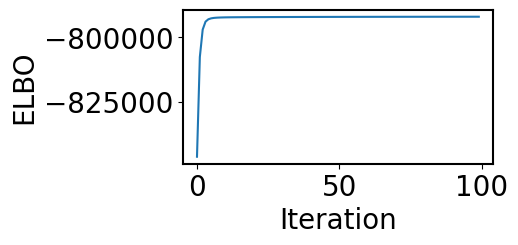

In [23]:
plt.figure(figsize=(4,2))
plt.plot(elbos)
plt.xlabel("Iteration")
plt.ylabel("ELBO");

In [24]:
log_lambdas = torch.zeros((Nk, Nc, Nt))
for k in range(Nk):
    for t in range(Nt):
        log_lambdas[k,:,t] = cavi.bs + cavi.betas[:,t] * y[k][t]

log_pis = log_lambdas - torch.logsumexp(log_lambdas, 1)[:,None,:]

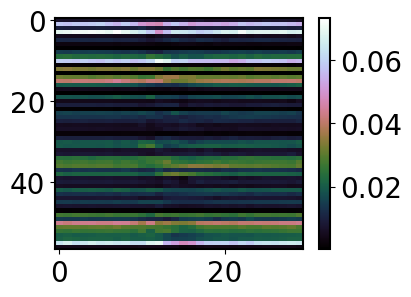

In [25]:
plt.figure(figsize=(4,3))
plt.imshow(torch.exp(log_pis.mean(0)).detach().numpy(), 
           aspect='auto', cmap='cubehelix')
plt.colorbar();

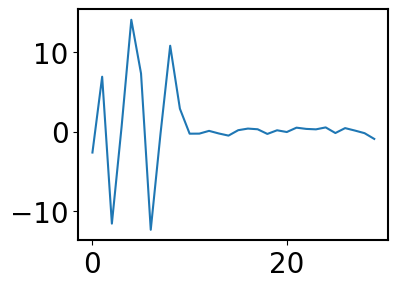

In [26]:
plt.figure(figsize=(4,3))
plt.plot(cavi.betas[-1,:].detach().numpy());

In [27]:
# gmm.means_

In [28]:
# cavi.means

In [29]:
cont_y_enc_res = {
    'bs': cavi.bs,
    'betas': cavi.betas,
    'means': cavi.means,
    'covs': cavi.covs
}
np.save(save_path + f'dy009_cont_y_enc_res_c{len(cavi.means)}.npy', cont_y_enc_res)

#### MoG only

In [30]:
all_trials = np.concatenate(np.concatenate(data_loader.trials))[:,1:]
spike_times = data_loader.data[:,0]

spike_labels = []
spike_probs = []
spike_labels.extend(gmm.predict(all_trials))
spike_probs.extend(gmm.predict_proba(all_trials))
spike_labels = np.array(spike_labels)
spike_probs = np.array(spike_probs)

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [31]:
enc_gmm = preprocess.compute_neural_activity(
    (spike_times, spike_labels, spike_probs),
    data_loader.stim_on_times,
    'clusterless', 
    n_time_bins=data_loader.n_t_bins
)
print(enc_gmm.shape)

(230, 57, 30)


In [16]:
train = data_loader.train_ids
test = data_loader.test_ids

In [33]:
x_train = enc_gmm.reshape(-1, enc_gmm.shape[1] * enc_gmm.shape[2])[train]
x_test = enc_gmm.reshape(-1, enc_gmm.shape[1] * enc_gmm.shape[2])[test]
y_train = data_loader.y[train]

ridge = Ridge(alpha=2000)
ridge.fit(x_train, y_train)
y_hat = ridge.predict(x_test)

In [34]:
print(f'R2 = {r2_score(data_loader.y[test], y_hat):.3f}')
print(f'MSE = {mean_squared_error(data_loader.y[test], y_hat):.3f}')
print(f'corr = {pearsonr(data_loader.y[test].flatten(), y_hat.flatten()).statistic:.3f}')

R2 = 0.049
MSE = 1.597
corr = 0.413


In [35]:
import time
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared, RationalQuadratic, RBF

long_term_trend_kernel = 50.0**2 * RBF(length_scale=50.0)
seasonal_kernel = (
    2.0**2
    * RBF(length_scale=100.0)
    * ExpSineSquared(length_scale=1.0, periodicity=1.0, periodicity_bounds="fixed")
)
# irregularities_kernel = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)
# noise_kernel = 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(
#     noise_level=0.1**2, noise_level_bounds=(1e-5, 1e5)
# )
kernel = (
    long_term_trend_kernel #+ seasonal_kernel + noise_kernel #+ irregularities_kernel 
)
gaussian_process = GaussianProcessRegressor(kernel=kernel, alpha=1e-10)
start_time = time.time()
gaussian_process.fit(x_train, y_train)
print(
    f"Time for GaussianProcessRegressor fitting: {time.time() - start_time:.3f} seconds"
)
gp_pred = gaussian_process.predict(x_test)
print(f'R2 = {r2_score(data_loader.y[test], gp_pred):.3f}')
print(f'MSE = {mean_squared_error(data_loader.y[test], gp_pred):.3f}')
print(f'corr = {pearsonr(data_loader.y[test].flatten(), gp_pred.flatten()).statistic:.3f}')

Time for GaussianProcessRegressor fitting: 0.703 seconds
R2 = 0.040
MSE = 1.372
corr = 0.538


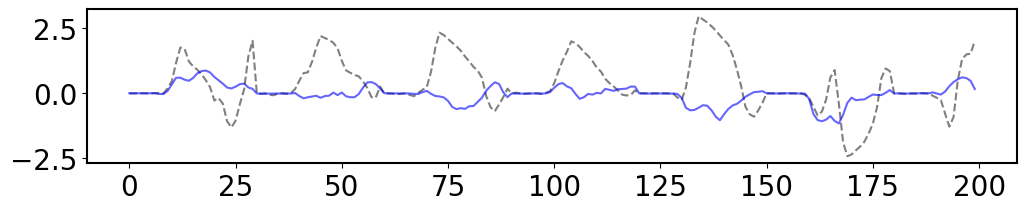

In [36]:
plt.figure(figsize=(12, 2))
plt.plot(data_loader.y[test].flatten()[:200], c='gray', linestyle='dashed', label='observed');
plt.plot(gp_pred.flatten()[:200], c='blue', alpha=.6, label='predicted');

In [37]:
windowed_enc_gmm, half_window_size, n_windows = decoder.sliding_window(
    enc_gmm, 
    data_loader.n_trials,
    window_size = 7
)
windowed_y = data_loader.y[:,half_window_size:n_windows].reshape(-1,1)

In [38]:
x_by_trial = windowed_enc_gmm.reshape((data_loader.n_trials, -1))
y_by_trial = windowed_y.reshape((data_loader.n_trials, -1))
x_train, x_test = x_by_trial[train], x_by_trial[test]
y_train, y_test = y_by_trial[train], y_by_trial[test]

x_train = x_train.reshape((-1, windowed_enc_gmm.shape[1]))
x_test = x_test.reshape((-1, windowed_enc_gmm.shape[1]))
y_train = y_train.flatten()
y_test = y_test.flatten()

ridge = Ridge(alpha=10000)
ridge.fit(x_train, y_train)
y_pred = ridge.predict(x_test)

In [39]:
print(f'R2 = {r2_score(y_test, y_pred):.3f}')
print(f'MSE = {mean_squared_error(y_test, y_pred):.3f}')
print(f'corr = {pearsonr(y_test, y_pred).statistic:.3f}')

R2 = 0.022
MSE = 2.162
corr = 0.225


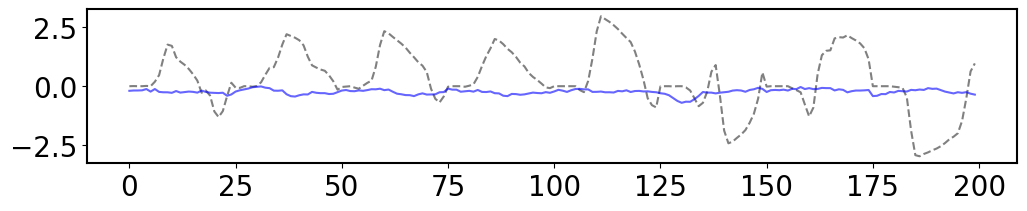

In [40]:
plt.figure(figsize=(12, 2))
plt.plot(y_test[:200], c='gray', linestyle='dashed', label='observed');
plt.plot(y_pred[:200], c='blue', alpha=.6, label='predicted');

#### encoding MoG

In [41]:
n_trials = stim_on_times.shape[0]
unsorted = np.vstack([unsorted_trials[i] for i in np.arange(n_trials)]) 
spike_times = unsorted[:,0]
spike_channels = unsorted[:,1]
spike_features = unsorted[:,2:]

thresholded_neural_data = preprocess.compute_neural_activity(
    (spike_times, spike_channels),
    stim_on_times,
    'thresholded', 
    n_time_bins=30,
    regional=True
)
print(f'thresholded neural data shape: {thresholded_neural_data.shape}')

thresholded neural data shape: (230, 39, 30)


In [42]:
x_train = thresholded_neural_data.reshape(-1, thresholded_neural_data.shape[1] * thresholded_neural_data.shape[2])[train]
x_test = thresholded_neural_data.reshape(-1, thresholded_neural_data.shape[1] * thresholded_neural_data.shape[2])[test]
y_train = data_loader.y[train]

In [43]:
import time
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared, RationalQuadratic, RBF

long_term_trend_kernel = 50.0**2 * RBF(length_scale=50.0)
seasonal_kernel = (
    2.0**2
    * RBF(length_scale=100.0)
    * ExpSineSquared(length_scale=1.0, periodicity=1.0, periodicity_bounds="fixed")
)
# irregularities_kernel = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)
# noise_kernel = 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(
#     noise_level=0.1**2, noise_level_bounds=(1e-5, 1e5)
# )
kernel = (
    long_term_trend_kernel #+ seasonal_kernel #+ irregularities_kernel + noise_kernel
)
gaussian_process = GaussianProcessRegressor(kernel=kernel, alpha=1e-2)
start_time = time.time()
gaussian_process.fit(x_train, y_train)
print(
    f"Time for GaussianProcessRegressor fitting: {time.time() - start_time:.3f} seconds"
)
gp_pred = gaussian_process.predict(x_test)
print(f'R2 = {r2_score(data_loader.y[test], gp_pred):.3f}')
print(f'MSE = {mean_squared_error(data_loader.y[test], gp_pred):.3f}')
print(f'corr = {pearsonr(data_loader.y[test].flatten(), gp_pred.flatten()).statistic:.3f}')

Time for GaussianProcessRegressor fitting: 0.827 seconds
R2 = 0.083
MSE = 0.970
corr = 0.714


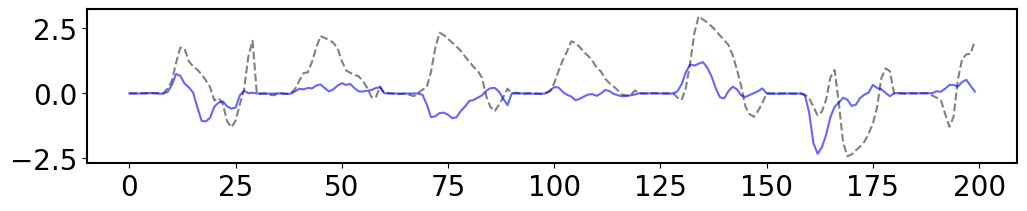

In [44]:
plt.figure(figsize=(12, 2))
plt.plot(data_loader.y[test].flatten()[:200], c='gray', linestyle='dashed', label='observed');
plt.plot(gp_pred.flatten()[:200], c='blue', alpha=.6, label='predicted');

In [45]:
ridge = Ridge(alpha=2000)
ridge.fit(x_train, y_train)
y_hat = ridge.predict(x_test)

In [46]:
print(f'R2 = {r2_score(data_loader.y[test], y_hat):.3f}')
print(f'MSE = {mean_squared_error(data_loader.y[test], y_hat):.3f}')
print(f'corr = {pearsonr(data_loader.y[test].flatten(), y_hat.flatten()).statistic:.3f}')

R2 = 0.145
MSE = 1.216
corr = 0.634


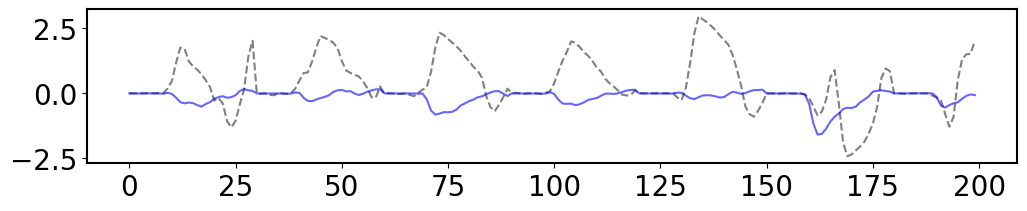

In [47]:
plt.figure(figsize=(12, 2))
plt.plot(data_loader.y[test].flatten()[:200], c='gray', linestyle='dashed', label='observed');
plt.plot(y_hat.flatten()[:200], c='blue', alpha=.6, label='predicted');

In [48]:
log_lambdas_hat = np.zeros((data_loader.n_trials, Nc, Nt))
for k in range(len(train)):
    for t in range(Nt):
        log_lambdas_hat[k,:,t] = cavi.bs.detach().numpy() + cavi.betas[:,t].detach().numpy() * y_train[k][t]

for k in range(len(test)):
    for t in range(Nt):
        log_lambdas_hat[k,:,t] = cavi.bs.detach().numpy() + cavi.betas[:,t].detach().numpy() * y_hat[k][t]

log_pis_hat = log_lambdas_hat - logsumexp(log_lambdas_hat, 1)[:,None,:]

In [49]:
enc_pis = np.exp(log_pis_hat)
enc_means = cavi.means.detach().numpy()
enc_covs = cavi.covs.detach().numpy()

In [50]:
enc_all = np.zeros((data_loader.n_trials, Nc, Nt))

for k in range(enc_all.shape[0]):
    for t in range(Nt):
        enc_gmm =  GaussianMixture(n_components=Nc, covariance_type='full')
        enc_gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(enc_covs))
        enc_gmm.weights_ = enc_pis[k,:,t]
        # enc_gmm.weights_ = enc_pis[:,:,t].mean(0)
        enc_gmm.means_ = enc_means
        enc_gmm.covariances_ = enc_covs
        if len(data_loader.trials[k][t]) > 0:
            enc_all[k,:,t] = enc_gmm.predict_proba(data_loader.trials[k][t][:,1:]).sum(0)

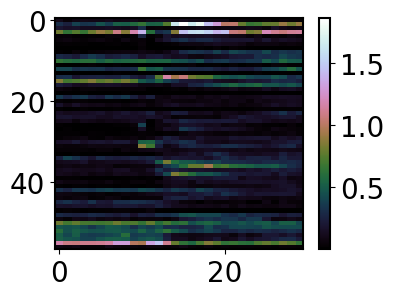

In [51]:
plt.figure(figsize=(4,3))
plt.imshow(enc_all.mean(0), aspect='auto', cmap='cubehelix')
plt.colorbar();

In [52]:
x_train = enc_all.reshape(-1, enc_all.shape[1] * enc_all.shape[2])[train]
x_test = enc_all.reshape(-1, enc_all.shape[1] * enc_all.shape[2])[test]
y_train = data_loader.y[train]

ridge = Ridge(alpha=2000)
ridge.fit(x_train, y_train)
y_hat = ridge.predict(x_test)

In [53]:
print(f'R2 = {r2_score(data_loader.y[test], y_hat):.3f}')
print(f'MSE = {mean_squared_error(data_loader.y[test], y_hat):.3f}')
print(f'corr = {pearsonr(data_loader.y[test].flatten(), y_hat.flatten()).statistic:.3f}')

R2 = 0.147
MSE = 1.239
corr = 0.622


In [54]:
import time
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared, RationalQuadratic, RBF

long_term_trend_kernel = 50.0**2 * RBF(length_scale=50.0)
seasonal_kernel = (
    2.0**2
    * RBF(length_scale=100.0)
    * ExpSineSquared(length_scale=1.0, periodicity=1.0, periodicity_bounds="fixed")
)
# irregularities_kernel = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)
# noise_kernel = 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(
#     noise_level=0.1**2, noise_level_bounds=(1e-5, 1e5)
# )
kernel = (
    long_term_trend_kernel #+ seasonal_kernel + noise_kernel #+ irregularities_kernel 
)
gaussian_process = GaussianProcessRegressor(kernel=kernel, alpha=1e-10)
start_time = time.time()
gaussian_process.fit(x_train, y_train)
print(
    f"Time for GaussianProcessRegressor fitting: {time.time() - start_time:.3f} seconds"
)
gp_pred = gaussian_process.predict(x_test)
print(f'R2 = {r2_score(data_loader.y[test], gp_pred):.3f}')
print(f'MSE = {mean_squared_error(data_loader.y[test], gp_pred):.3f}')
print(f'corr = {pearsonr(data_loader.y[test].flatten(), gp_pred.flatten()).statistic:.3f}')

Time for GaussianProcessRegressor fitting: 0.767 seconds
R2 = 0.085
MSE = 0.998
corr = 0.698


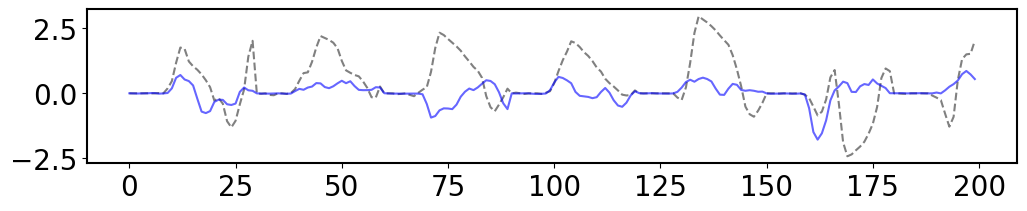

In [55]:
plt.figure(figsize=(12, 2))
plt.plot(data_loader.y[test].flatten()[:200], c='gray', linestyle='dashed', label='observed');
plt.plot(gp_pred.flatten()[:200], c='blue', alpha=.6, label='predicted');

In [56]:
windowed_enc_all, half_window_size, n_windows = decoder.sliding_window(
    enc_all, 
    data_loader.n_trials,
    window_size = 7
)
windowed_y = data_loader.y[:,half_window_size:n_windows].reshape(-1,1)

In [57]:
x_by_trial = windowed_enc_all.reshape((data_loader.n_trials, -1))
y_by_trial = windowed_y.reshape((data_loader.n_trials, -1))
x_train, x_test = x_by_trial[train], x_by_trial[test]
y_train, y_test = y_by_trial[train], y_by_trial[test]

x_train = x_train.reshape((-1, windowed_enc_all.shape[1]))
x_test = x_test.reshape((-1, windowed_enc_all.shape[1]))
y_train = y_train.flatten()
y_test = y_test.flatten()

In [58]:
ridge = Ridge(alpha=10000)
ridge.fit(x_train, y_train)
y_pred = ridge.predict(x_test)

In [59]:
print(f'R2 = {r2_score(y_test, y_pred):.3f}')
print(f'MSE = {mean_squared_error(y_test, y_pred):.3f}')
print(f'corr = {pearsonr(y_test, y_pred).statistic:.3f}')

R2 = 0.141
MSE = 1.897
corr = 0.440


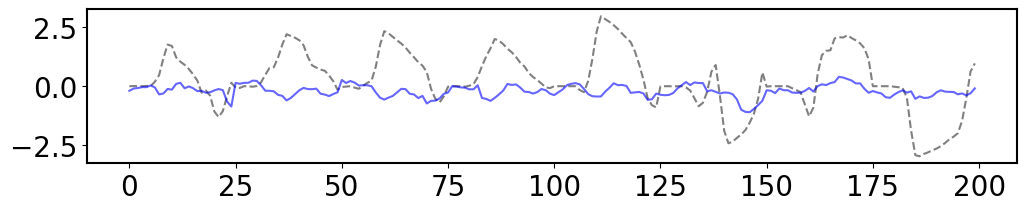

In [60]:
plt.figure(figsize=(12, 2))
plt.plot(y_test[:200], c='gray', linestyle='dashed', label='observed');
plt.plot(y_pred[:200], c='blue', alpha=.6, label='predicted');

#### thresholded

In [61]:
windowed_thresh, half_window_size, n_windows = decoder.sliding_window(
    thresholded_neural_data, 
    data_loader.n_trials,
    window_size = 7
)
windowed_y = data_loader.y[:,half_window_size:n_windows].reshape(-1,1)

In [62]:
x_by_trial = windowed_thresh.reshape((data_loader.n_trials, -1))
y_by_trial = windowed_y.reshape((data_loader.n_trials, -1))
x_train, x_test = x_by_trial[train], x_by_trial[test]
y_train, y_test = y_by_trial[train], y_by_trial[test]

x_train = x_train.reshape((-1, windowed_thresh.shape[1]))
x_test = x_test.reshape((-1, windowed_thresh.shape[1]))
y_train = y_train.flatten()
y_test = y_test.flatten()

In [63]:
ridge = Ridge(alpha=10000)
ridge.fit(x_train, y_train)
y_pred = ridge.predict(x_test)

In [64]:
print(f'R2 = {r2_score(y_test, y_pred):.3f}')
print(f'MSE = {mean_squared_error(y_test, y_pred):.3f}')
print(f'corr = {pearsonr(y_test, y_pred).statistic:.3f}')

R2 = 0.114
MSE = 1.957
corr = 0.385


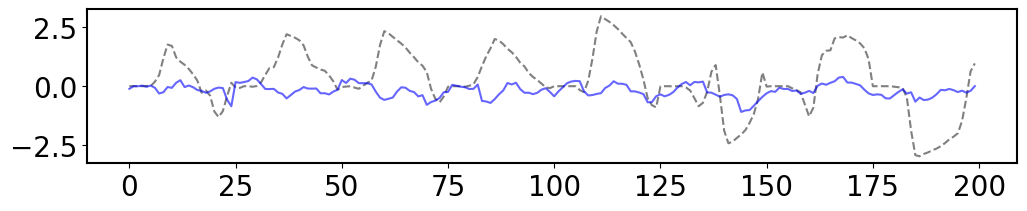

In [65]:
plt.figure(figsize=(12, 2))
plt.plot(y_test[:200], c='gray', linestyle='dashed', label='observed');
plt.plot(y_pred[:200], c='blue', alpha=.6, label='predicted');

#### KS & good IBL units

In [59]:
n_trials = stim_on_times.shape[0]
sorted = np.vstack([sorted_trials[i] for i in np.arange(n_trials)]) 
spike_times = sorted[:,0]
spike_clusters = sorted[:,1]

sorted_neural_data = preprocess.compute_neural_activity(
    (spike_times, spike_clusters),
    stim_on_times,
    'sorted', 
    n_time_bins=30,
    regional=True
)
print(f'sorted neural data shape: {sorted_neural_data.shape}')

good_sorted = np.vstack([good_sorted_trials[i] for i in np.arange(n_trials)]) 
spike_times = good_sorted[:,0]
spike_clusters = good_sorted[:,1]

good_sorted_neural_data = preprocess.compute_neural_activity(
    (spike_times, spike_clusters),
    stim_on_times,
    'sorted', 
    n_time_bins=30,
    regional=True
)
print(f'good sorted neural data shape: {good_sorted_neural_data.shape}')

sorted neural data shape: (230, 453, 30)
good sorted neural data shape: (230, 85, 30)


In [60]:
x_train = sorted_neural_data.reshape(-1, sorted_neural_data.shape[1] * sorted_neural_data.shape[2])[train]
x_test = sorted_neural_data.reshape(-1, sorted_neural_data.shape[1] * sorted_neural_data.shape[2])[test]
y_train = data_loader.y[train]

ridge = Ridge(alpha=2000)
ridge.fit(x_train, y_train)
y_hat = ridge.predict(x_test)

In [61]:
print(f'R2 = {r2_score(data_loader.y[test], y_hat):.3f}')
print(f'MSE = {mean_squared_error(data_loader.y[test], y_hat):.3f}')
print(f'corr = {pearsonr(data_loader.y[test].flatten(), y_hat.flatten()).statistic:.3f}')

R2 = -0.491
MSE = 37176.677
corr = 0.643


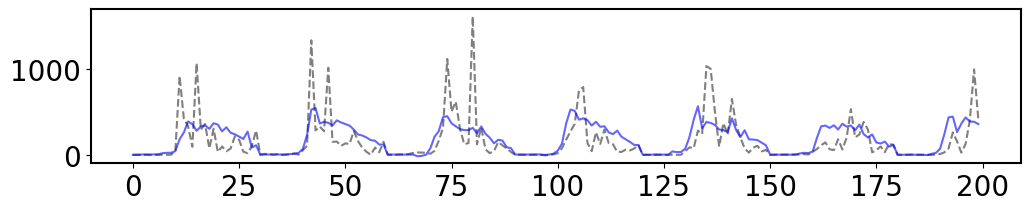

In [62]:
plt.figure(figsize=(12, 2))
plt.plot(data_loader.y[test].flatten()[:200], c='gray', linestyle='dashed', label='observed');
plt.plot(y_hat.flatten()[:200], c='blue', alpha=.6, label='predicted');

In [ ]:
import time
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared, RationalQuadratic, RBF

long_term_trend_kernel = 50.0**2 * RBF(length_scale=50.0)
seasonal_kernel = (
    2.0**2
    * RBF(length_scale=100.0)
    * ExpSineSquared(length_scale=1.0, periodicity=1.0, periodicity_bounds="fixed")
)
irregularities_kernel = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)
noise_kernel = 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(
    noise_level=0.1**2, noise_level_bounds=(1e-5, 1e5)
)
kernel = (
    long_term_trend_kernel + seasonal_kernel #+ noise_kernel #+ irregularities_kernel
)
gaussian_process = GaussianProcessRegressor(kernel=kernel, alpha=1e-2)
start_time = time.time()
gaussian_process.fit(x_train, y_train)
print(
    f"Time for GaussianProcessRegressor fitting: {time.time() - start_time:.3f} seconds"
)
gp_pred = gaussian_process.predict(x_test)
print(f'R2 = {r2_score(data_loader.y[test], gp_pred):.3f}')
print(f'MSE = {mean_squared_error(data_loader.y[test], gp_pred):.3f}')
print(f'corr = {pearsonr(data_loader.y[test].flatten(), gp_pred.flatten()).statistic:.3f}')

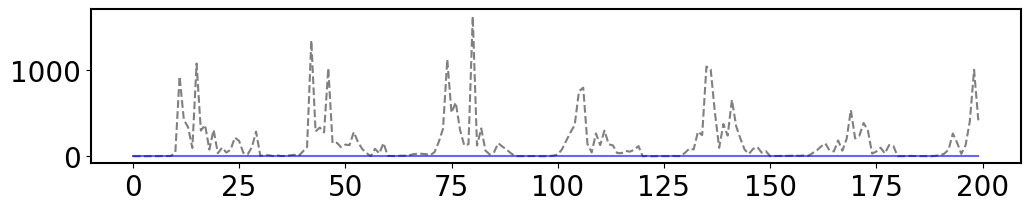

In [64]:
plt.figure(figsize=(12, 2))
plt.plot(data_loader.y[test].flatten()[:200], c='gray', linestyle='dashed', label='observed');
plt.plot(gp_pred.flatten()[:200], c='blue', alpha=.6, label='predicted');

In [65]:
windowed_sorted, half_window_size, n_windows = decoder.sliding_window(
    sorted_neural_data, 
    data_loader.n_trials,
    window_size = 7
)

windowed_good_units, half_window_size, n_windows = decoder.sliding_window(
    good_sorted_neural_data, 
    data_loader.n_trials,
    window_size = 7
)
windowed_y = data_loader.y[:,half_window_size:n_windows].reshape(-1,1)

In [66]:
x_by_trial = windowed_sorted.reshape((data_loader.n_trials, -1))
y_by_trial = windowed_y.reshape((data_loader.n_trials, -1))
x_train, x_test = x_by_trial[train], x_by_trial[test]
y_train, y_test = y_by_trial[train], y_by_trial[test]

x_train = x_train.reshape((-1, windowed_sorted.shape[1]))
x_test = x_test.reshape((-1, windowed_sorted.shape[1]))
y_train = y_train.flatten()
y_test = y_test.flatten()

ridge = Ridge(alpha=2000)
ridge.fit(x_train, y_train)
y_pred = ridge.predict(x_test)

In [67]:
print(f'R2 = {r2_score(y_test, y_pred):.3f}')
print(f'MSE = {mean_squared_error(y_test, y_pred):.3f}')
print(f'corr = {pearsonr(y_test, y_pred).statistic:.3f}')

R2 = 0.290
MSE = 49117.629
corr = 0.539


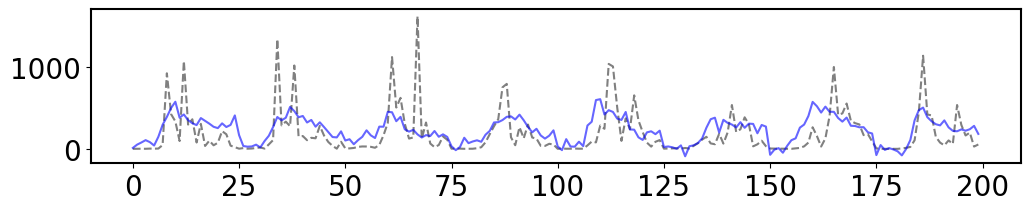

In [68]:
plt.figure(figsize=(12, 2))
plt.plot(y_test[:200], c='gray', linestyle='dashed', label='observed');
plt.plot(y_pred[:200], c='blue', alpha=.6, label='predicted');

In [69]:
x_train = good_sorted_neural_data.reshape(-1, good_sorted_neural_data.shape[1] * good_sorted_neural_data.shape[2])[train]
x_test = good_sorted_neural_data.reshape(-1, good_sorted_neural_data.shape[1] * good_sorted_neural_data.shape[2])[test]
y_train = data_loader.y[train]

ridge = Ridge(alpha=2000)
ridge.fit(x_train, y_train)
y_hat = ridge.predict(x_test)

In [70]:
print(f'R2 = {r2_score(data_loader.y[test], y_hat):.3f}')
print(f'MSE = {mean_squared_error(data_loader.y[test], y_hat):.3f}')
print(f'corr = {pearsonr(data_loader.y[test].flatten(), y_hat.flatten()).statistic:.3f}')

R2 = -0.269
MSE = 38835.766
corr = 0.623


In [ ]:
import time
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared, RationalQuadratic, RBF

long_term_trend_kernel = 50.0**2 * RBF(length_scale=50.0)
seasonal_kernel = (
    2.0**2
    * RBF(length_scale=100.0)
    * ExpSineSquared(length_scale=1.0, periodicity=1.0, periodicity_bounds="fixed")
)
# irregularities_kernel = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)
noise_kernel = 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(
    noise_level=0.1**2, noise_level_bounds=(1e-5, 1e5)
)
kernel = (
    long_term_trend_kernel #+ seasonal_kernel + noise_kernel #+ irregularities_kernel
)
gaussian_process = GaussianProcessRegressor(kernel=kernel, alpha=1e-2)
start_time = time.time()
gaussian_process.fit(x_train, y_train)
print(
    f"Time for GaussianProcessRegressor fitting: {time.time() - start_time:.3f} seconds"
)
gp_pred = gaussian_process.predict(x_test)
print(f'R2 = {r2_score(data_loader.y[test], gp_pred):.3f}')
print(f'MSE = {mean_squared_error(data_loader.y[test], gp_pred):.3f}')
print(f'corr = {pearsonr(data_loader.y[test].flatten(), gp_pred.flatten()).statistic:.3f}')

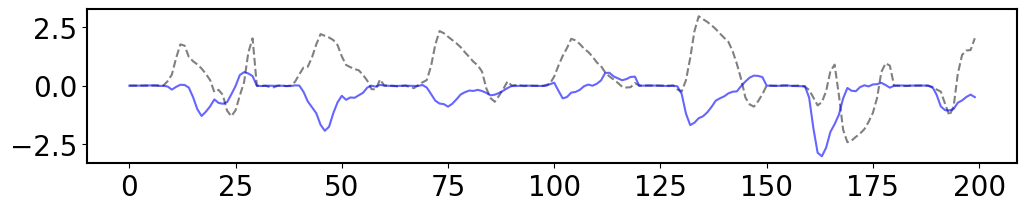

In [78]:
plt.figure(figsize=(12, 2))
plt.plot(data_loader.y[test].flatten()[:200], c='gray', linestyle='dashed', label='observed');
plt.plot(gp_pred.flatten()[:200], c='blue', alpha=.6, label='predicted');

In [72]:
x_by_trial = windowed_good_units.reshape((data_loader.n_trials, -1))
y_by_trial = windowed_y.reshape((data_loader.n_trials, -1))
x_train, x_test = x_by_trial[train], x_by_trial[test]
y_train, y_test = y_by_trial[train], y_by_trial[test]

x_train = x_train.reshape((-1, windowed_good_units.shape[1]))
x_test = x_test.reshape((-1, windowed_good_units.shape[1]))
y_train = y_train.flatten()
y_test = y_test.flatten()

ridge = Ridge(alpha=2000)
ridge.fit(x_train, y_train)
y_pred = ridge.predict(x_test)

In [73]:
print(f'R2 = {r2_score(y_test, y_pred):.3f}')
print(f'MSE = {mean_squared_error(y_test, y_pred):.3f}')
print(f'corr = {pearsonr(y_test, y_pred).statistic:.3f}')

R2 = 0.234
MSE = 52978.360
corr = 0.484


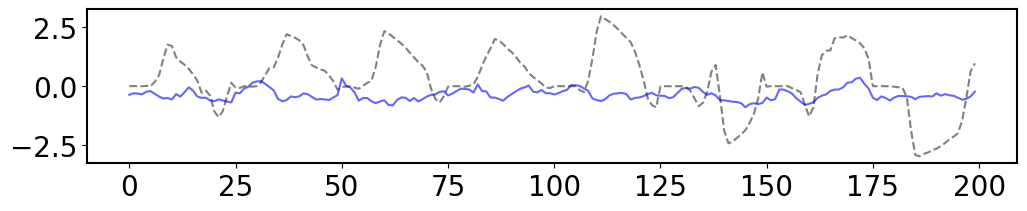

In [81]:
plt.figure(figsize=(12, 2))
plt.plot(y_test[:200], c='gray', linestyle='dashed', label='observed');
plt.plot(y_pred[:200], c='blue', alpha=.6, label='predicted');

#### DY-009

In [4]:
all_good_units_r2 = [0.094, 0.133, -0.021, 0.119, 0.221]
all_all_units_r2 = [0.242, 0.235, 0.094, 0.240, 0.065]
all_thresh_r2 = [0.233, 0.230, 0.064, 0.220, 0.225]
all_mog_r2 = [0.235, 0.212, 0.064, 0.206, 0.208]
all_enc_mog_r2 = [0.235, 0.220, 0.067, 0.217, 0.203]

all_good_units_mse = [1.352, 0.912, 1.228, 1.067, 0.750]
all_all_units_mse = [0.935, 0.710, 1.128, 0.823, 0.989]
all_thresh_mse = [0.964, 0.717, 1.162, 0.831, 0.680]
all_mog_mse = [0.939, 0.724, 1.168, 0.857, 0.722]
all_enc_mog_mse = [0.942, 0.706, 1.183, 0.832, 0.726]

all_good_units_corr = [0.565, 0.717, 0.637, 0.698, 0.784]
all_all_units_corr = [0.732, 0.803,  0.673, 0.779, 0.696]
all_thresh_corr = [0.720, 0.797, 0.662, 0.775, 0.808]
all_mog_corr = [0.728, 0.796, 0.660, 0.765, 0.793]
all_enc_mog_corr = [0.727, 0.804, 0.655, 0.772, 0.791]

print(f'good units R2: {np.mean(all_good_units_r2):.3f} MSE: {np.mean(all_good_units_mse):.3f} corr: {np.mean(all_good_units_corr):.3f}')
print(f'all units R2: {np.mean(all_all_units_r2):.3f} MSE: {np.mean(all_all_units_mse):.3f} corr: {np.mean(all_all_units_corr):.3f}')
print(f'thresholded R2: {np.mean(all_thresh_r2):.3f} MSE: {np.mean(all_thresh_mse):.3f} corr: {np.mean(all_thresh_corr):.3f}')
print(f'MoG R2: {np.mean(all_mog_r2):.3f} MSE: {np.mean(all_mog_mse):.3f} corr: {np.mean(all_mog_corr):.3f}')
print(f'encoded-MoG R2: {np.mean(all_enc_mog_r2):.3f} MSE: {np.mean(all_enc_mog_mse):.3f} corr: {np.mean(all_enc_mog_corr):.3f}')

good units R2: 0.109 MSE: 1.062 corr: 0.680
all units R2: 0.175 MSE: 0.917 corr: 0.737
thresholded R2: 0.194 MSE: 0.871 corr: 0.752
MoG R2: 0.185 MSE: 0.882 corr: 0.748
encoded-MoG R2: 0.188 MSE: 0.878 corr: 0.750


In [83]:
po_good_units_r2 = [0.008, 0.058, 0.066, 0.046, 0.068]
po_all_units_r2 = [0.159, 0.164, 0.119, 0.135, 0.140]
po_thresh_r2 = [0.138, 0.123, 0.099, 0.130, 0.145]
po_mog_r2 = [0.102, 0.048, 0.028, 0.064, 0.049]
po_enc_mog_r2 = [0.154, 0.170, 0.104, 0.135, 0.147]

po_good_units_mse = [1.685, 1.219, 1.447, 1.423, 1.535]
po_all_units_mse = [1.175, 0.889, 1.284, 1.193, 1.253]
po_thresh_mse = [1.248, 1.011, 1.323, 1.209, 1.216]
po_mog_mse = [1.329, 1.281, 1.547, 1.378, 1.597]
po_enc_mog_mse = [1.180, 0.892, 1.308, 1.191, 1.239]

po_good_units_corr = [0.413, 0.574, 0.633, 0.654, 0.578]
po_all_units_corr = [0.636, 0.733, 0.645, 0.696, 0.693]
po_thresh_corr = [0.607, 0.678, 0.604, 0.686, 0.714]
po_mog_corr = [0.573, 0.558, 0.587, 0.630, 0.538]
po_enc_mog_corr = [0.634, 0.730, 0.607, 0.694, 0.698]

print(f'PO good units R2: {np.mean(po_good_units_r2):.3f} MSE: {np.mean(po_good_units_mse):.3f} corr: {np.mean(po_good_units_corr):.3f}')
print(f'PO all units R2: {np.mean(po_all_units_r2):.3f} MSE: {np.mean(po_all_units_mse):.3f} corr: {np.mean(po_all_units_corr):.3f}')
print(f'PO thresholded R2: {np.mean(po_thresh_r2):.3f} MSE: {np.mean(po_thresh_mse):.3f} corr: {np.mean(po_thresh_corr):.3f}')
print(f'PO MoG R2: {np.mean(po_mog_r2):.3f} MSE: {np.mean(po_mog_mse):.3f} corr: {np.mean(po_mog_corr):.3f}')
print(f'PO encoded-MoG R2: {np.mean(po_enc_mog_r2):.3f} MSE: {np.mean(po_enc_mog_mse):.3f} corr: {np.mean(po_enc_mog_corr):.3f}')

PO good units R2: 0.049 MSE: 1.462 corr: 0.570
PO all units R2: 0.143 MSE: 1.159 corr: 0.681
PO thresholded R2: 0.127 MSE: 1.201 corr: 0.658
PO MoG R2: 0.058 MSE: 1.426 corr: 0.577
PO encoded-MoG R2: 0.142 MSE: 1.162 corr: 0.673


In [84]:
lp_good_units_r2 = [0.004, -0.079, -0.137, -0.086, -0.039]
lp_all_units_r2 = [0.157, 0.119, 0.036, 0.086, 0.139]
lp_thresh_r2 = [0.126, 0.069, -0.010, 0.066, 0.060]
lp_mog_r2 = [0.053, 0.057, -0.004, -0.062, -0.016]
lp_enc_mog_r2 = [0.151, 0.082, 0.033, 0.063, 0.060]

lp_good_units_mse = [1.646, 1.638, 1.719, 1.705, 1.603]
lp_all_units_mse = [1.122, 1.119, 1.284, 1.141, 1.127]
lp_thresh_mse = [1.235, 1.237, 1.402, 1.236, 1.260]
lp_mog_mse = [1.513, 1.310, 1.463, 1.559, 1.555]
lp_enc_mog_mse = [1.136, 1.179, 1.291, 1.251, 1.321]

lp_good_units_corr = [0.407, 0.316, 0.467, 0.427, 0.389]
lp_all_units_corr = [0.667, 0.624, 0.617, 0.679, 0.645]
lp_thresh_corr = [0.614, 0.528, 0.568, 0.646, 0.584]
lp_mog_corr = [0.484, 0.564, 0.557, 0.505, 0.432]
lp_enc_mog_corr = [0.662, 0.593, 0.613, 0.636, 0.554]

print(f'LP good units R2: {np.mean(lp_good_units_r2):.3f} MSE: {np.mean(lp_good_units_mse):.3f} corr: {np.mean(lp_good_units_corr):.3f}')
print(f'LP all units R2: {np.mean(lp_all_units_r2):.3f} MSE: {np.mean(lp_all_units_mse):.3f} corr: {np.mean(lp_all_units_corr):.3f}')
print(f'LP thresholded R2: {np.mean(lp_thresh_r2):.3f} MSE: {np.mean(lp_thresh_mse):.3f} corr: {np.mean(lp_thresh_corr):.3f}')
print(f'LP MoG R2: {np.mean(lp_mog_r2):.3f} MSE: {np.mean(lp_mog_mse):.3f} corr: {np.mean(lp_mog_corr):.3f}')
print(f'LP encoded-MoG R2: {np.mean(lp_enc_mog_r2):.3f} MSE: {np.mean(lp_enc_mog_mse):.3f} corr: {np.mean(lp_enc_mog_corr):.3f}')

LP good units R2: -0.067 MSE: 1.662 corr: 0.401
LP all units R2: 0.107 MSE: 1.159 corr: 0.646
LP thresholded R2: 0.062 MSE: 1.274 corr: 0.588
LP MoG R2: 0.006 MSE: 1.480 corr: 0.508
LP encoded-MoG R2: 0.078 MSE: 1.236 corr: 0.612


In [85]:
dg_good_units_r2 = [0.003, 0.008, -0.016, -0.013, -0.045]
dg_all_units_r2 = [0.019, 0.031, -0.010, 0.009, -0.011]
dg_thresh_r2 = [-0.001, 0.014, -0.033, 0.007, -0.025]
dg_mog_r2 = [-0.007, -0.018, -0.060, -0.023, -0.052]
dg_enc_mog_r2 = [0.019, 0.023, -0.021, 0.012, 0.007]

dg_good_units_mse = [1.770, 1.654, 1.714, 1.601, 1.778]
dg_all_units_mse = [1.710, 1.590, 1.692, 1.537, 1.643]
dg_thresh_mse = [1.755, 1.630, 1.727, 1.510, 1.678]
dg_mog_mse = [1.803, 1.721, 1.813, 1.609, 1.783]
dg_enc_mog_mse = [1.703, 1.611, 1.690, 1.509, 1.565]

dg_good_units_corr = [0.324, 0.310, 0.437, 0.552, 0.303]
dg_all_units_corr = [0.369, 0.361, 0.446, 0.579, 0.384]
dg_thresh_corr = [0.342, 0.334, 0.415, 0.575, 0.354]
dg_mog_corr = [0.307, 0.265, 0.362, 0.519, 0.265]
dg_enc_mog_corr = [0.373, 0.342, 0.434, 0.579, 0.425]

print(f'DG good units R2: {np.mean(dg_good_units_r2):.3f} MSE: {np.mean(dg_good_units_mse):.3f} corr: {np.mean(dg_good_units_corr):.3f}')
print(f'DG all units R2: {np.mean(dg_all_units_r2):.3f} MSE: {np.mean(dg_all_units_mse):.3f} corr: {np.mean(dg_all_units_corr):.3f}')
print(f'DG thresholded R2: {np.mean(dg_thresh_r2):.3f} MSE: {np.mean(dg_thresh_mse):.3f} corr: {np.mean(dg_thresh_corr):.3f}')
print(f'DG MoG R2: {np.mean(dg_mog_r2):.3f} MSE: {np.mean(dg_mog_mse):.3f} corr: {np.mean(dg_mog_corr):.3f}')
print(f'DG encoded-MoG R2: {np.mean(dg_enc_mog_r2):.3f} MSE: {np.mean(dg_enc_mog_mse):.3f} corr: {np.mean(dg_enc_mog_corr):.3f}')

DG good units R2: -0.013 MSE: 1.703 corr: 0.385
DG all units R2: 0.008 MSE: 1.634 corr: 0.428
DG thresholded R2: -0.008 MSE: 1.660 corr: 0.404
DG MoG R2: -0.032 MSE: 1.746 corr: 0.344
DG encoded-MoG R2: 0.008 MSE: 1.616 corr: 0.431


In [82]:
ca1_good_units_r2 = [0.010, -0.045, -0.044, -0.065, -0.032]
ca1_all_units_r2 = [0.041, -0.047, -0.010, -0.054, 0.018]
ca1_thresh_r2 = [0.029, -0.034, -0.016, -0.087, 0.018]
ca1_mog_r2 = [0.008, -0.042, -0.048, -0.078, -0.031]
ca1_enc_mog_r2 = [0.030, -0.042, -0.006, -0.053, 0.014]

ca1_good_units_mse = [1.700, 1.736, 1.716, 1.715, 1.706]
ca1_all_units_mse = [1.642, 1.767, 1.656, 1.718, 1.693]
ca1_thresh_mse = [1.664, 1.733, 1.676, 1.814, 1.701]
ca1_mog_mse = [1.755, 1.731, 1.811, 1.781, 1.835]
ca1_enc_mog_mse = [1.659, 1.713, 1.623, 1.704, 1.648]

ca1_good_units_corr = [0.376, 0.258, 0.423, 0.453, 0.344]
ca1_all_units_corr = [0.417, 0.232, 0.457, 0.454, 0.360]
ca1_thresh_corr = [0.404, 0.248, 0.445, 0.393, 0.356]
ca1_mog_corr = [0.334, 0.237, 0.374, 0.423, 0.248]
ca1_enc_mog_corr = [0.404, 0.270,0.467, 0.465, 0.385]

print(f'CA1 good units R2: {np.mean(ca1_good_units_r2):.3f} MSE: {np.mean(ca1_good_units_mse):.3f} corr: {np.mean(ca1_good_units_corr):.3f}')
print(f'CA1 all units R2: {np.mean(ca1_all_units_r2):.3f} MSE: {np.mean(ca1_all_units_mse):.3f} corr: {np.mean(ca1_all_units_corr):.3f}')
print(f'CA1 thresholded R2: {np.mean(ca1_thresh_r2):.3f} MSE: {np.mean(ca1_thresh_mse):.3f} corr: {np.mean(ca1_thresh_corr):.3f}')
print(f'CA1 MoG R2: {np.mean(ca1_mog_r2):.3f} MSE: {np.mean(ca1_mog_mse):.3f} corr: {np.mean(ca1_mog_corr):.3f}')
print(f'CA1 encoded-MoG R2: {np.mean(ca1_enc_mog_r2):.3f} MSE: {np.mean(ca1_enc_mog_mse):.3f} corr: {np.mean(ca1_enc_mog_corr):.3f}')

CA1 good units R2: -0.035 MSE: 1.715 corr: 0.371
CA1 all units R2: -0.010 MSE: 1.695 corr: 0.384
CA1 thresholded R2: -0.018 MSE: 1.718 corr: 0.369
CA1 MoG R2: -0.038 MSE: 1.783 corr: 0.323
CA1 encoded-MoG R2: -0.011 MSE: 1.669 corr: 0.398


In [5]:
vis_good_units_r2 = [-0.073, -0.049, -0.332, -0.031, -0.011]
vis_all_units_r2 = [0.053, 0.109, -0.068, 0.044, -0.049]
vis_thresh_r2 = [0.028, 0.048, -0.094, 0.022, -0.012]
vis_mog_r2 = [-0.017, 0.024, -0.152, -0.007, -0.059]
vis_enc_mog_r2 = [0.062, 0.089, -0.065, 0.026, -0.058]

vis_good_units_mse = [1.731, 1.482, 1.724, 1.646, 1.523]
vis_all_units_mse = [1.335, 1.074, 1.334, 1.444, 1.404]
vis_thresh_mse = [1.500, 1.172, 1.509, 1.524, 1.426]
vis_mog_mse = [1.637, 1.405, 1.737, 1.581, 1.726]
vis_enc_mog_mse = [1.375, 1.069, 1.446, 1.503, 1.437]

vis_good_units_corr = [0.357, 0.425, 0.429, 0.514, 0.449]
vis_all_units_corr = [0.570, 0.639, 0.616, 0.624, 0.521]
vis_thresh_corr = [0.493, 0.594, 0.536, 0.569, 0.499]
vis_mog_corr = [0.414, 0.474, 0.440, 0.524, 0.346]
vis_enc_mog_corr = [0.552, 0.640, 0.560, 0.576, 0.500]

print(f'VIS good units R2: {np.mean(vis_good_units_r2):.3f} MSE: {np.mean(vis_good_units_mse):.3f} corr: {np.mean(vis_good_units_corr):.3f}')
print(f'VIS all units R2: {np.mean(vis_all_units_r2):.3f} MSE: {np.mean(vis_all_units_mse):.3f} corr: {np.mean(vis_all_units_corr):.3f}')
print(f'VIS thresholded R2: {np.mean(vis_thresh_r2):.3f} MSE: {np.mean(vis_thresh_mse):.3f} corr: {np.mean(vis_thresh_corr):.3f}')
print(f'VIS MoG R2: {np.mean(vis_mog_r2):.3f} MSE: {np.mean(vis_mog_mse):.3f} corr: {np.mean(vis_mog_corr):.3f}')
print(f'VIS encoded-MoG R2: {np.mean(vis_enc_mog_r2):.3f} MSE: {np.mean(vis_enc_mog_mse):.3f} corr: {np.mean(vis_enc_mog_corr):.3f}')

VIS good units R2: -0.099 MSE: 1.621 corr: 0.435
VIS all units R2: 0.018 MSE: 1.318 corr: 0.594
VIS thresholded R2: -0.002 MSE: 1.426 corr: 0.538
VIS MoG R2: -0.042 MSE: 1.617 corr: 0.440
VIS encoded-MoG R2: 0.011 MSE: 1.366 corr: 0.566


#### DY-016

In [7]:
all_good_units_r2 = [0.255, 0.315, 0.224, 0.253]
all_all_units_r2 = [0.362, 0.403, 0.304, 0.315]
all_thresh_r2 = [0.300, 0.322, 0.337, 0.305]
all_mog_r2 = [0.319, 0.339, 0.313, 0.310]
all_enc_mog_r2 = [0.349, 0.354, 0.304, 0.358]

all_good_units_mse = [2.263, 1.724, 1.661, 1.811]
all_all_units_mse = [1.938, 1.503, 1.489, 1.662]
all_thresh_mse = [2.125, 1.707, 1.420, 1.684]
all_mog_mse = [2.070, 1.662, 1.470, 1.556]
all_enc_mog_mse = [1.976, 1.626, 1.491, 1.674]

all_good_units_corr = [0.509, 0.569, 0.474, 0.508]
all_all_units_corr = [0.603, 0.638, 0.554, 0.561]
all_thresh_corr = [0.553, 0.568, 0.580, 0.554]
all_mog_corr = [0.574, 0.584, 0.560, 0.557]
all_enc_mog_corr = [0.602, .599, 0.553, 0.602]

print(f'good units R2: {np.mean(all_good_units_r2):.3f} MSE: {np.mean(all_good_units_mse):.3f} corr: {np.mean(all_good_units_corr):.3f}')
print(f'all units R2: {np.mean(all_all_units_r2):.3f} MSE: {np.mean(all_all_units_mse):.3f} corr: {np.mean(all_all_units_corr):.3f}')
print(f'thresholded R2: {np.mean(all_thresh_r2):.3f} MSE: {np.mean(all_thresh_mse):.3f} corr: {np.mean(all_thresh_corr):.3f}')
print(f'MoG R2: {np.mean(all_mog_r2):.3f} MSE: {np.mean(all_mog_mse):.3f} corr: {np.mean(all_mog_corr):.3f}')
print(f'encoded-MoG R2: {np.mean(all_enc_mog_r2):.3f} MSE: {np.mean(all_enc_mog_mse):.3f} corr: {np.mean(all_enc_mog_corr):.3f}')

good units R2: 0.262 MSE: 1.865 corr: 0.515
all units R2: 0.346 MSE: 1.648 corr: 0.589
thresholded R2: 0.316 MSE: 1.734 corr: 0.564
MoG R2: 0.320 MSE: 1.690 corr: 0.569
encoded-MoG R2: 0.341 MSE: 1.692 corr: 0.589


In [8]:
po_good_units_r2 = [0.124, 0.124, 0.032, 0.163]
po_all_units_r2 = [0.203, 0.177, 0.100, 0.211]
po_thresh_r2 = [0.178, 0.150, 0.126, 0.181]
po_mog_r2 = [0.125, 0.100, 0.078, 0.137]
po_enc_mog_r2 = [0.186, 0.163, 0.194, 0.208]

po_good_units_mse = [2.661, 2.125, 2.072, 2.107]
po_all_units_mse = [2.419, 1.995, 1.926, 1.985]
po_thresh_mse = [2.497, 2.062, 1.871, 2.061]
po_mog_mse = [2.658, 2.183, 1.974, 2.172]
po_enc_mog_mse = [2.473, 2.029, 1.726, 1.993]

po_good_units_corr = [0.357, 0.353, 0.229, 0.410]
po_all_units_corr = [0.459, 0.423, 0.334, 0.461]
po_thresh_corr = [0.427, 0.394, 0.368, 0.426]
po_mog_corr = [0.357, 0.319, 0.304, 0.372]
po_enc_mog_corr = [0.445, 0.488, 0.446, 0.467]

print(f'PO good units R2: {np.mean(po_good_units_r2):.3f} MSE: {np.mean(po_good_units_mse):.3f} corr: {np.mean(po_good_units_corr):.3f}')
print(f'PO all units R2: {np.mean(po_all_units_r2):.3f} MSE: {np.mean(po_all_units_mse):.3f} corr: {np.mean(po_all_units_corr):.3f}')
print(f'PO thresholded R2: {np.mean(po_thresh_r2):.3f} MSE: {np.mean(po_thresh_mse):.3f} corr: {np.mean(po_thresh_corr):.3f}')
print(f'PO MoG R2: {np.mean(po_mog_r2):.3f} MSE: {np.mean(po_mog_mse):.3f} corr: {np.mean(po_mog_corr):.3f}')
print(f'PO encoded-MoG R2: {np.mean(po_enc_mog_r2):.3f} MSE: {np.mean(po_enc_mog_mse):.3f} corr: {np.mean(po_enc_mog_corr):.3f}')

PO good units R2: 0.111 MSE: 2.241 corr: 0.337
PO all units R2: 0.173 MSE: 2.081 corr: 0.419
PO thresholded R2: 0.159 MSE: 2.123 corr: 0.404
PO MoG R2: 0.110 MSE: 2.247 corr: 0.338
PO encoded-MoG R2: 0.188 MSE: 2.055 corr: 0.462


In [3]:
lp_good_units_r2 = [0.093, 0.067, 0.063, 0.111, 0.072]
lp_all_units_r2 = [0.145, 0.102, 0.118, 0.184, 0.110]
lp_thresh_r2 = [0.084, 0.072, 0.077, 0.102, 0.079]
lp_mog_r2 = [0.004, -0.029, 0.009, -0.009, -0.005]
lp_enc_mog_r2 = [0.091, 0.078, 0.084, 0.111, 0.098]

lp_good_units_mse = [1.982, 1.631, 1.678, 1.353, 1.553]
lp_all_units_mse = [1.749, 1.520, 1.517, 1.155, 1.403]
lp_thresh_mse = [1.973, 1.609, 1.615, 1.362, 1.505]
lp_mog_mse = [2.283, 1.873, 1.802, 1.656, 1.793]
lp_enc_mog_mse = [1.963, 1.594, 1.619, 1.342, 1.460]

lp_good_units_corr = [0.537, 0.534, 0.477, 0.557, 0.553]
lp_all_units_corr = [0.628, 0.577, 0.550,  0.650, 0.610]
lp_thresh_corr = [0.533, 0.538, 0.506, 0.551, 0.571]
lp_mog_corr = [0.387, 0.410, 0.412, 0.382, 0.423]
lp_enc_mog_corr = [0.539, 0.547, 0.505, 0.561, 0.589]

print(f'LP good units R2: {np.mean(lp_good_units_r2):.3f} MSE: {np.mean(lp_good_units_mse):.3f} corr: {np.mean(lp_good_units_corr):.3f}')
print(f'LP all units R2: {np.mean(lp_all_units_r2):.3f} MSE: {np.mean(lp_all_units_mse):.3f} corr: {np.mean(lp_all_units_corr):.3f}')
print(f'LP thresholded R2: {np.mean(lp_thresh_r2):.3f} MSE: {np.mean(lp_thresh_mse):.3f} corr: {np.mean(lp_thresh_corr):.3f}')
print(f'LP MoG R2: {np.mean(lp_mog_r2):.3f} MSE: {np.mean(lp_mog_mse):.3f} corr: {np.mean(lp_mog_corr):.3f}')
print(f'LP encoded-MoG R2: {np.mean(lp_enc_mog_r2):.3f} MSE: {np.mean(lp_enc_mog_mse):.3f} corr: {np.mean(lp_enc_mog_corr):.3f}')

LP good units R2: 0.081 MSE: 1.639 corr: 0.532
LP all units R2: 0.132 MSE: 1.469 corr: 0.603
LP thresholded R2: 0.083 MSE: 1.613 corr: 0.540
LP MoG R2: -0.006 MSE: 1.881 corr: 0.403
LP encoded-MoG R2: 0.092 MSE: 1.596 corr: 0.548


In [30]:
dg_good_units_r2 = [-0.007, -0.005, -0.001, -0.013, -0.009]
dg_all_units_r2 = [-0.014, -0.002, -0.014, -0.003, -0.015]
dg_thresh_r2 = [-0.022, -0.005, -0.014, -0.001, -0.011]
dg_mog_r2 = [-0.018, -0.023, -0.014, -0.002, -0.023]
dg_enc_mog_r2 = [-0.020, 0.009, -0.018, 0.011, 0.009]

dg_good_units_mse = [2.371, 1.887, 1.877, 1.681, 1.835]
dg_all_units_mse = [2.388, 1.859, 1.908, 1.652, 1.846]
dg_thresh_mse = [2.376, 1.837, 1.892, 1.638, 1.826]
dg_mog_mse = [2.378, 1.920, 1.893, 1.640, 1.855]
dg_enc_mog_mse = [2.374, 1.799, 1.919, 1.608, 1.762]

dg_good_units_corr = [0.338, 0.405, 0.367, 0.363, 0.400]
dg_all_units_corr = [0.329, 0.420, 0.348, 0.381, 0.393]
dg_thresh_corr = [0.337, 0.431, 0.358, 0.390, 0.404]
dg_mog_corr = [0.335, 0.384, 0.357, 0.388, 0.387]
dg_enc_mog_corr = [0.338, 0.452, 0.342, 0.408, 0.440]

print(f'DG good units R2: {np.mean(dg_good_units_r2):.3f} MSE: {np.mean(dg_good_units_mse):.3f} corr: {np.mean(dg_good_units_corr):.3f}')
print(f'DG all units R2: {np.mean(dg_all_units_r2):.3f} MSE: {np.mean(dg_all_units_mse):.3f} corr: {np.mean(dg_all_units_corr):.3f}')
print(f'DG thresholded R2: {np.mean(dg_thresh_r2):.3f} MSE: {np.mean(dg_thresh_mse):.3f} corr: {np.mean(dg_thresh_corr):.3f}')
print(f'DG MoG R2: {np.mean(dg_mog_r2):.3f} MSE: {np.mean(dg_mog_mse):.3f} corr: {np.mean(dg_mog_corr):.3f}')
print(f'DG encoded-MoG R2: {np.mean(dg_enc_mog_r2):.3f} MSE: {np.mean(dg_enc_mog_mse):.3f} corr: {np.mean(dg_enc_mog_corr):.3f}')

DG good units R2: -0.007 MSE: 1.930 corr: 0.375
DG all units R2: -0.010 MSE: 1.931 corr: 0.374
DG thresholded R2: -0.011 MSE: 1.914 corr: 0.384
DG MoG R2: -0.016 MSE: 1.937 corr: 0.370
DG encoded-MoG R2: -0.002 MSE: 1.892 corr: 0.396


In [4]:
ca1_good_units_r2 = [-0.037, 0.016, 0.092, 0.089, -0.033]
ca1_all_units_r2 = [-0.058, 0.056, 0.093, 0.093, -0.037]
ca1_thresh_r2 = [-0.021, 0.049, 0.061, 0.118, -0.008]
ca1_mog_r2 = [-0.065, 0.024, 0.053, 0.066,  -0.028]
ca1_enc_mog_r2 = [-0.025, 0.075, 0.067, 0.081, -0.002]

ca1_good_units_mse = [1.923, 2.380, 2.758, 1.951, 1.846]
ca1_all_units_mse = [1.928, 2.285, 2.756, 1.941, 1.861]
ca1_thresh_mse = [1.833, 2.300, 2.851, 1.888, 1.790]
ca1_mog_mse = [1.948, 2.362, 2.877, 2.000, 1.838]
ca1_enc_mog_mse = [1.815, 2.239, 2.834, 1.967, 1.769]

ca1_good_units_corr = [0.388, 0.167, 0.317, 0.299, 0.392]
ca1_all_units_corr = [0.391, 0.254, 0.306, 0.306, 0.385]
ca1_thresh_corr = [0.431, 0.234, 0.248, 0.349, 0.425]
ca1_mog_corr = [0.370, 0.176, 0.232, 0.257, 0.398]
ca1_enc_mog_corr = [0.440, 0.288, 0.268, 0.316, 0.435]

print(f'CA1 good units R2: {np.mean(ca1_good_units_r2):.3f} MSE: {np.mean(ca1_good_units_mse):.3f} corr: {np.mean(ca1_good_units_corr):.3f}')
print(f'CA1 all units R2: {np.mean(ca1_all_units_r2):.3f} MSE: {np.mean(ca1_all_units_mse):.3f} corr: {np.mean(ca1_all_units_corr):.3f}')
print(f'CA1 thresholded R2: {np.mean(ca1_thresh_r2):.3f} MSE: {np.mean(ca1_thresh_mse):.3f} corr: {np.mean(ca1_thresh_corr):.3f}')
print(f'CA1 MoG R2: {np.mean(ca1_mog_r2):.3f} MSE: {np.mean(ca1_mog_mse):.3f} corr: {np.mean(ca1_mog_corr):.3f}')
print(f'CA1 encoded-MoG R2: {np.mean(ca1_enc_mog_r2):.3f} MSE: {np.mean(ca1_enc_mog_mse):.3f} corr: {np.mean(ca1_enc_mog_corr):.3f}')

CA1 good units R2: 0.025 MSE: 2.172 corr: 0.313
CA1 all units R2: 0.029 MSE: 2.154 corr: 0.328
CA1 thresholded R2: 0.040 MSE: 2.132 corr: 0.337
CA1 MoG R2: 0.010 MSE: 2.205 corr: 0.287
CA1 encoded-MoG R2: 0.039 MSE: 2.125 corr: 0.349


In [5]:
vis_good_units_r2 = [-0.009, -0.008, -0.003, -0.002, -0.005]
vis_all_units_r2 = [0.003, 0.001, 0.016, 0.011, 0.002]
vis_thresh_r2 = [-0.005, 0.002, 0.003, 0.004, -0.004]
vis_mog_r2 = [-0.012, -0.011, -0.015, -0.017]
vis_enc_mog_r2 = [-0.003, 0.003, 0.005, 0.003, -0.002]

vis_good_units_mse = [2.378, 1.882, 1.886, 1.648, 1.825]
vis_all_units_mse = [2.349, 1.849, 1.837, 1.623, 1.814]
vis_thresh_mse = [2.371, 1.856, 1.868, 1.633, 1.821]
vis_mog_mse = [2.393, 1.905, 1.672, 1.854]
vis_enc_mog_mse = [2.365, 1.856, 1.863, 1.634, 1.815]

vis_good_units_corr = [0.335, 0.407, 0.361, 0.383, 0.406]
vis_all_units_corr = [0.350, 0.426, 0.390, 0.399, 0.412]
vis_thresh_corr = [0.339, 0.423, 0.372, 0.394, 0.408]
vis_mog_corr = [0.327, 0.349, 0.370, 0.387]
vis_enc_mog_corr = [0.342, 0.422, 0.375, 0.393, 0.412]

print(f'VIS good units R2: {np.mean(vis_good_units_r2):.3f} MSE: {np.mean(vis_good_units_mse):.3f} corr: {np.mean(vis_good_units_corr):.3f}')
print(f'VIS all units R2: {np.mean(vis_all_units_r2):.3f} MSE: {np.mean(vis_all_units_mse):.3f} corr: {np.mean(vis_all_units_corr):.3f}')
print(f'VIS thresholded R2: {np.mean(vis_thresh_r2):.3f} MSE: {np.mean(vis_thresh_mse):.3f} corr: {np.mean(vis_thresh_corr):.3f}')
print(f'VIS MoG R2: {np.mean(vis_mog_r2):.3f} MSE: {np.mean(vis_mog_mse):.3f} corr: {np.mean(vis_mog_corr):.3f}')
print(f'VIS encoded-MoG R2: {np.mean(vis_enc_mog_r2):.3f} MSE: {np.mean(vis_enc_mog_mse):.3f} corr: {np.mean(vis_enc_mog_corr):.3f}')

VIS good units R2: -0.005 MSE: 1.924 corr: 0.378
VIS all units R2: 0.007 MSE: 1.894 corr: 0.395
VIS thresholded R2: 0.000 MSE: 1.910 corr: 0.387
VIS MoG R2: -0.014 MSE: 1.956 corr: 0.358
VIS encoded-MoG R2: 0.001 MSE: 1.907 corr: 0.389


#### plotting

In [34]:
dy09_good_units = np.array([
    [0.565, 0.717, 0.637, 0.698, 0.784],
    [0.413, 0.574, 0.633, 0.654, 0.578],
    [0.407, 0.316, 0.467, 0.427, 0.389],
    [0.324, 0.310, 0.437, 0.552, 0.303],
    [0.376, 0.258, 0.423, 0.453, 0.344],
    [0.357, 0.425, 0.429, 0.514, 0.449]
])

dy09_sorted = np.array([
    [0.732, 0.803,  0.673, 0.779, 0.696],
    [0.636, 0.733, 0.645, 0.696, 0.693],
    [0.667, 0.624, 0.617, 0.679, 0.645],
    [0.369, 0.361, 0.446, 0.579, 0.384],
    [0.417, 0.232, 0.457, 0.454, 0.360],
    [0.570, 0.639, 0.616, 0.624, 0.521]
])

dy09_thresholded = np.array([
    [0.720, 0.797, 0.662, 0.775, 0.808],
    [0.607, 0.678, 0.604, 0.686, 0.714],
    [0.614, 0.528, 0.568, 0.646, 0.584],
    [0.342, 0.334, 0.415, 0.575, 0.354],
    [0.404, 0.248, 0.445, 0.393, 0.356],
    [0.493, 0.594, 0.536, 0.569, 0.499]
])


dy09_clusterless = np.array([
    [0.727, 0.804, 0.655, 0.772, 0.791],
    [0.634, 0.730, 0.607, 0.694, 0.698],
    [0.662, 0.593, 0.613, 0.636, 0.554],
    [0.373, 0.342, 0.434, 0.579, 0.425],
    [0.404, 0.270, 0.467, 0.465, 0.385],
    [0.552, 0.640, 0.560, 0.576, 0.500]
])

dy16_good_units = np.array([
    [0.509, 0.569, 0.474, 0.508, 0.508],
    [0.357, 0.353, 0.229, 0.410, 0.410],
    [0.537, 0.534, 0.477, 0.557, 0.553],
    [0.338, 0.405, 0.367, 0.363, 0.400],
    [0.388, 0.167, 0.317, 0.299, 0.392],
    [0.335, 0.407, 0.361, 0.383, 0.406]
])

dy16_sorted = np.array([
    [0.603, 0.638, 0.554, 0.561, 0.561],
    [0.459, 0.423, 0.334, 0.461, 0.461],
    [0.628, 0.577, 0.550,  0.650, 0.610],
    [0.329, 0.420, 0.348, 0.381, 0.393],
    [0.391, 0.254, 0.306, 0.306, 0.385],
    [0.350, 0.426, 0.390, 0.399, 0.412]
])

dy16_thresholded = np.array([
    [0.553, 0.568, 0.580, 0.554, 0.554],
    [0.427, 0.394, 0.368, 0.426, 0.426],
    [0.533, 0.538, 0.506, 0.551, 0.571],
    [0.337, 0.431, 0.358, 0.390, 0.404],
    [0.431, 0.234, 0.248, 0.349, 0.425],
    [0.339, 0.423, 0.372, 0.394, 0.408]
])

dy16_clusterless = np.array([
    [0.602, .599, 0.553, 0.602, 0.602], 
    [0.445, 0.488, 0.446, 0.467, 0.467],
    [0.539, 0.547, 0.505, 0.561, 0.589],
    [0.338, 0.452, 0.342, 0.408, 0.440],
    [0.440, 0.288, 0.268, 0.316, 0.435],
    [0.342, 0.422, 0.375, 0.393, 0.412]
])

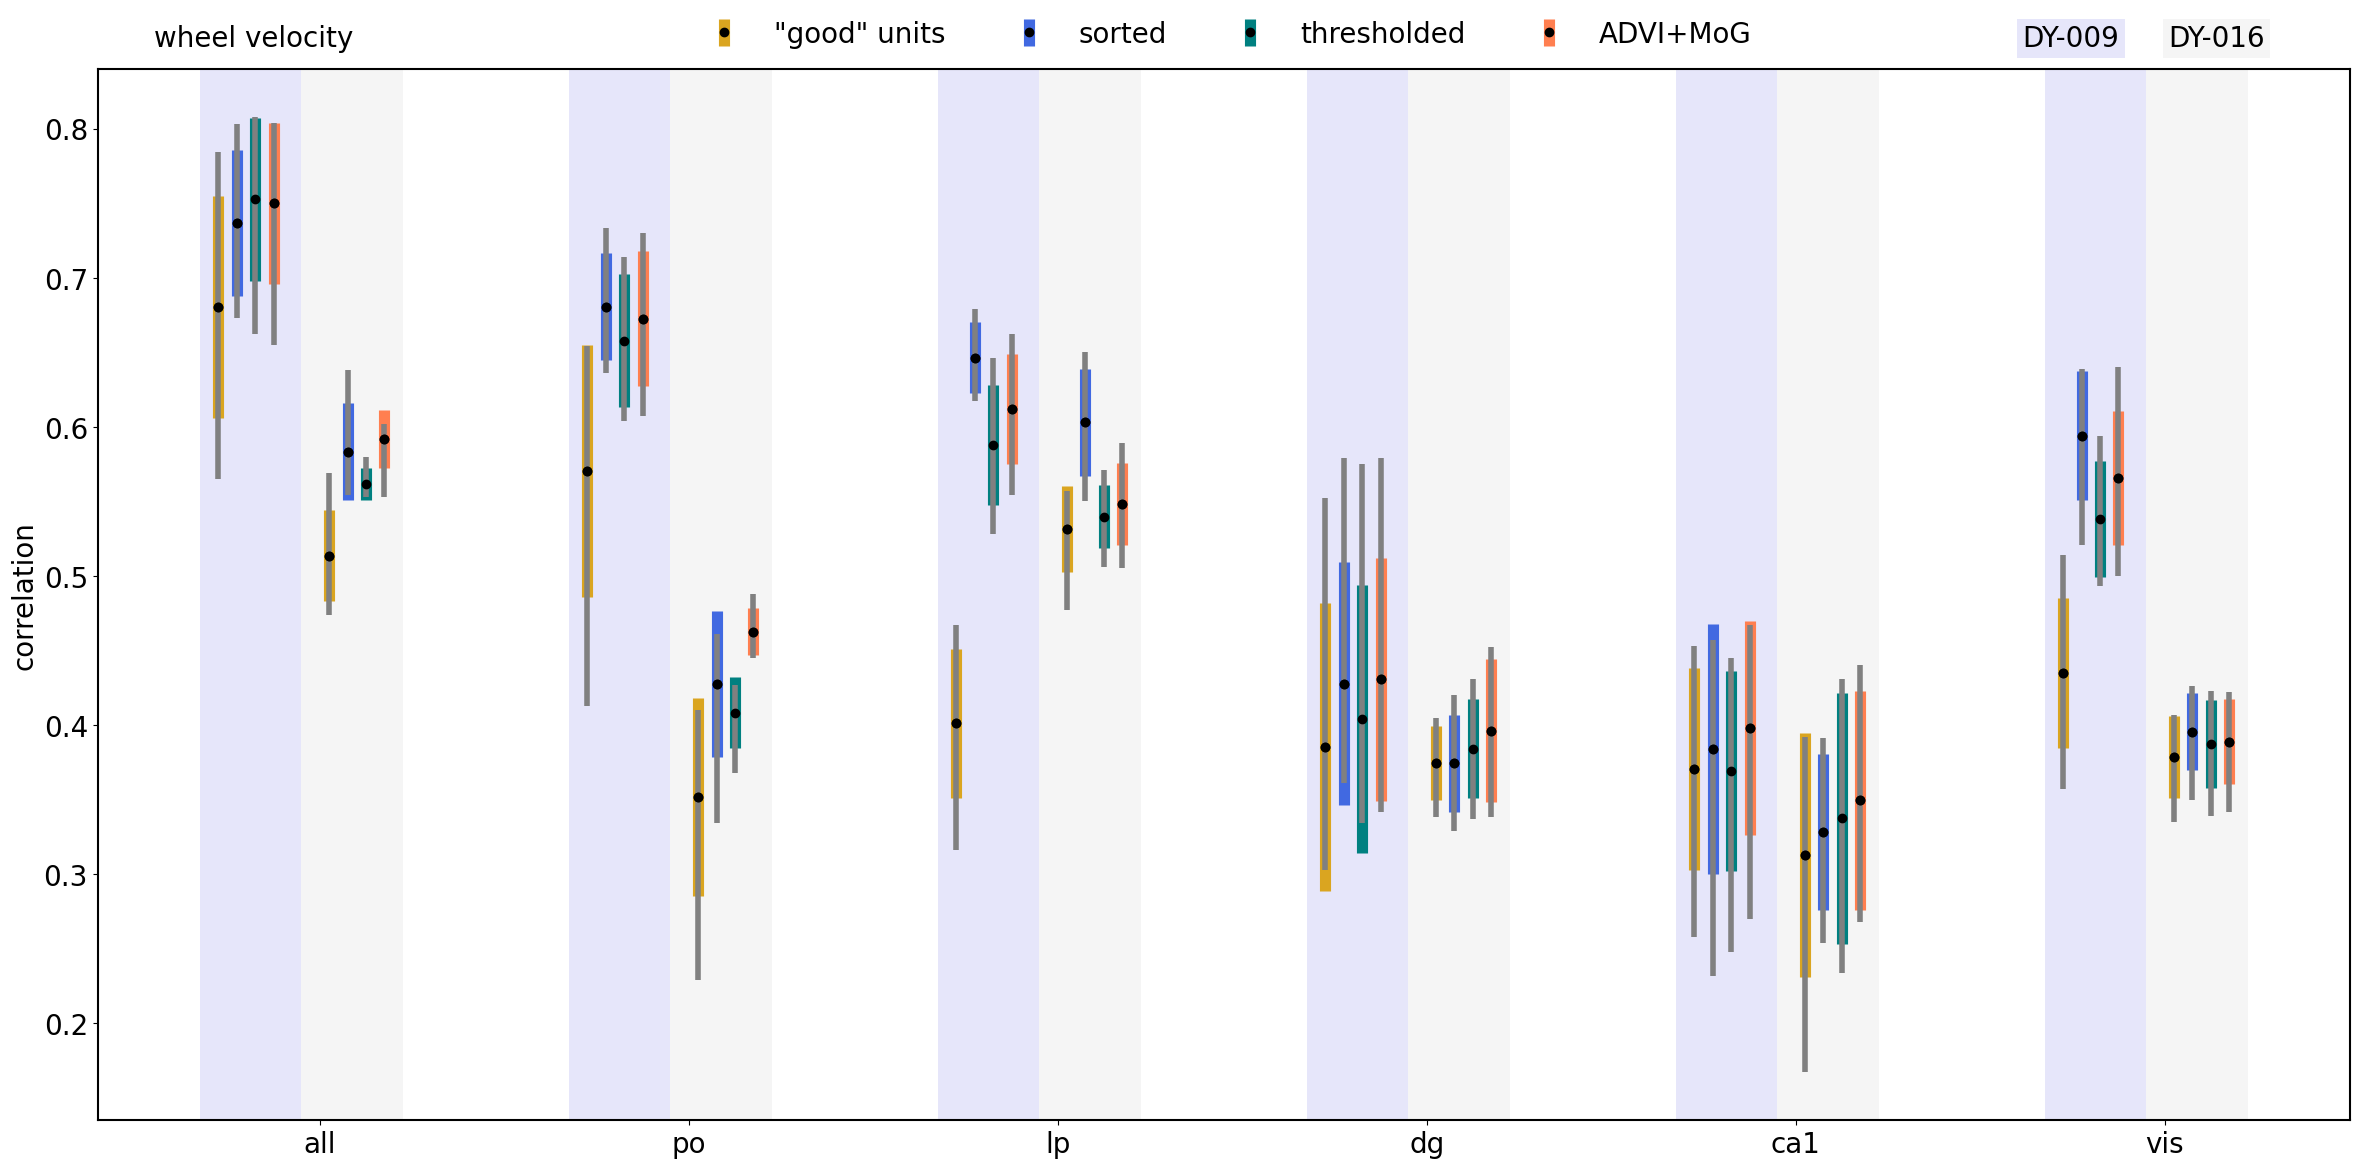

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(24, 12))

ticks = ['all', 'po', 'lp', 'dg', 'ca1', 'vis']

mins, maxs, means, stds = dy16_good_units.min(1), dy16_good_units.max(1), dy16_good_units.mean(1), dy16_good_units.std(1)
ax.errorbar(np.arange(len(ticks))*2-.2, means, stds, 
                 fmt='ok', ecolor='goldenrod', lw=8, label='"good" units')
ax.errorbar(np.arange(len(ticks))*2-.2, means, [means - mins, maxs - means],
                 fmt='ok', ecolor='gray', lw=4)

mins, maxs, means, stds = dy09_good_units.min(1), dy09_good_units.max(1), dy09_good_units.mean(1), dy09_good_units.std(1)
ax.errorbar(np.arange(len(ticks))*2-.8, means, stds, 
                 fmt='ok', ecolor='goldenrod', lw=8)
ax.errorbar(np.arange(len(ticks))*2-.8, means, [means - mins, maxs - means],
                 fmt='ok', ecolor='gray', lw=4)

mins, maxs, means, stds = dy16_sorted.min(1), dy16_sorted.max(1), dy16_sorted.mean(1), dy16_sorted.std(1)
ax.errorbar(np.arange(len(ticks))*2-.1, means, stds, 
                 fmt='ok', ecolor='royalblue', lw=8, label='sorted')
ax.errorbar(np.arange(len(ticks))*2-.1, means, [means - mins, maxs - means],
                 fmt='ok', ecolor='gray', lw=4)

mins, maxs, means, stds = dy09_sorted.min(1), dy09_sorted.max(1), dy09_sorted.mean(1), dy09_sorted.std(1)
ax.errorbar(np.arange(len(ticks))*2-.7, means, stds, 
                 fmt='ok', ecolor='royalblue', lw=8)
ax.errorbar(np.arange(len(ticks))*2-.7, means, [means - mins, maxs - means],
                 fmt='ok', ecolor='gray', lw=4)

mins, maxs, means, stds = dy16_thresholded.min(1), dy16_thresholded.max(1), dy16_thresholded.mean(1), dy16_thresholded.std(1)
ax.errorbar(np.arange(len(ticks))*2, means, stds, 
             fmt='ok', ecolor='teal', lw=8, label='thresholded')
ax.errorbar(np.arange(len(ticks))*2, means, [means - mins, maxs - means],
                 fmt='.k', ecolor='gray', lw=4)

mins, maxs, means, stds = dy09_thresholded.min(1), dy09_thresholded.max(1), dy09_thresholded.mean(1), dy09_thresholded.std(1)
ax.errorbar(np.arange(len(ticks))*2-.6, means, stds, 
             fmt='ok', ecolor='teal', lw=8)
ax.errorbar(np.arange(len(ticks))*2-.6, means, [means - mins, maxs - means],
                 fmt='.k', ecolor='gray', lw=4)

mins, maxs, means, stds = dy16_clusterless.min(1), dy16_clusterless.max(1), dy16_clusterless.mean(1), dy16_clusterless.std(1)
ax.errorbar(np.arange(len(ticks))*2+.1, means, stds, 
             fmt='ok', ecolor='coral', lw=8, label='ADVI+MoG')
ax.errorbar(np.arange(len(ticks))*2+.1, means, [means - mins, maxs - means],
                 fmt='ok', ecolor='gray', lw=4)

mins, maxs, means, stds = dy09_clusterless.min(1), dy09_clusterless.max(1), dy09_clusterless.mean(1), dy09_clusterless.std(1)
ax.errorbar(np.arange(len(ticks))*2-.5, means, stds, 
             fmt='ok', ecolor='coral', lw=8)
ax.errorbar(np.arange(len(ticks))*2-.5, means, [means - mins, maxs - means],
                 fmt='ok', ecolor='gray', lw=4)

ax.legend(loc='lower left')
ax.set_xticks([-.25, 1.75, 3.75, 5.75, 7.75, 9.75], ticks)
ax.set_ylabel('correlation')
ax.text(-1.15, .855, 'wheel velocity')

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.07),
          ncol=4, fancybox=False, shadow=False, frameon=False)

ax.axvspan(-.9, -.35, facecolor='lavender')
ax.axvspan(-.35, .2, facecolor='whitesmoke')
ax.axvspan(1.1, 1.65, facecolor='lavender')
ax.axvspan(1.65, 2.2, facecolor='whitesmoke')
ax.axvspan(3.1, 3.65, facecolor='lavender')
ax.axvspan(3.65, 4.2, facecolor='whitesmoke')
ax.axvspan(5.1, 5.65, facecolor='lavender')
ax.axvspan(5.65, 6.2, facecolor='whitesmoke')
ax.axvspan(7.1, 7.65, facecolor='lavender')
ax.axvspan(7.65, 8.2, facecolor='whitesmoke')
ax.axvspan(9.1, 9.65, facecolor='lavender')
ax.axvspan(9.65, 10.2, facecolor='whitesmoke')

ax.text(8.98, .855, 'DY-009', bbox={'facecolor': 'lavender', 'edgecolor':'none', 'pad':4})
ax.text(9.77, .855, 'DY-016', bbox={'facecolor': 'whitesmoke', 'edgecolor':'none', 'pad':4})

plt.tight_layout()
# plt.savefig('compare_decoders_wheel_velocity.png', dpi=400)